#Alicia's analysis of March 03 2016 RP data:
* 15 libraries:  1-12 ("rpA5") are hrGFP rich/leu/arg +/- torin1(250nM), ragbwt, and ragbq99l rich/leu/arg. prepped by polyA tailing RPFs, RT, circ, rRNA subtractive hyb, 6 cycles pcr amplification to linearize & add illumina adpators. 13-15 ("rpA1") are hrGFP rich, leu and ragbq99l leu prepped by RNaseH-based rRNA subtraction, linker ligation to RPFs, RT, circ, &12-14 cycles of pcr.  See ribosome profiling blog post [link](http://oshealab.rc.fas.harvard.edu/cancer/2015/07/06/20150706-alicia-ribosome-profiling-in-hek293t-ragbq99lragbwthrgfp-cell-lines/)
* used our "old" analysis method developed by Rasi Subramaniam for initial analysis of 2013/2014 rp experiments in human cells. 

##Step 1: polyA trimming

In [ ]:
#run from odyssey server on raw fastq.gz files.
#repeated for Lane2 fastq.gz files
for file in /n/osheafs1/LAB/alicia/data/htseq/20160303_293TAAVS1crispr_hrGFP-ragbwt-ragbq99l_richleuargtorin1_pluslinkerlibs/Lane1/*{lib1,2,3,4,5,6,7,8,9,10,11,12}*.fastq.gz; do python /n/osheafs1/LAB/alicia/bin/scripts/polyAtrimmer.py $file; usleep 100000;done

for file in /n/osheafs1/LAB/alicia/data/htseq/20160303_293TAAVS1crispr_hrGFP-ragbwt-ragbq99l_richleuargtorin1_pluslinkerlibs/Lane2/*{lib1,2,3,4,5,6,7,8,9,10,11,12}*.fastq.gz; do python /n/osheafs1/LAB/alicia/bin/scripts/polyAtrimmer.py $file; usleep 100000;done
#output = fastq_trimmed files. ~95-98% of reads should pass.

##Step 2: linker trimming

In [ ]:
#first I modified the polyAtrimmer.py script below to trim linker seq instead. then use code in next cell to run on odyssey server.

#!/usr/bin/env python

'''
This script trims the Ingolia 2012 linker sequence from fastq single-end Illumina reads.
Author: Arvind R. Subramaniam, Harvard University. Modified slightly by Alicia Darnell.
Date: 03 Mar 2016
'''

import re #regular expression library.
import argparse #to parse arguments.
import gzip #library to handle gzipped files.
from Bio.SeqIO.QualityIO import FastqGeneralIterator

#parse arguments using the argparse module.
#----------------------
parser = argparse.ArgumentParser( description='Trim Ingolia 2012 linker seq and subsequent 3\' region from fastq single-end Illumina reads.\
Required python modules: gzip, re, argparse, Bio.SeqIO.QualityIO. Output: trimmed reads fastq file and file containing reads that fall outside size cutoff.\
Note that reads that do not have the linker are discarded.' )
parser.add_argument( 'inputFile', metavar='INPUTFILE', help='fastq input filename, can be compressed in .gz format' )
parser.add_argument( '--extraTrim', dest='extraTrimmingLength', type=int, default=1, help='trim these many nt 5\' to the linker (default: 1)' )
parser.add_argument( '--end5Trim', dest='end5TrimmingLength', type=int, default=1, help='trim these many nt at the 5\' end before writing output. Note that this length is not counted for the thresholds (default: 1) ' )
parser.add_argument( '--minResidualLength', dest='remainingLength', type=int, default=13, help='only retain reads that are at least this many nt long after discarding linker + extraTrimmingLength (default: 13)' )
inputFile = parser.parse_args( ).inputFile
extraTrimmingLength = parser.parse_args( ).extraTrimmingLength
end5TrimmingLength = parser.parse_args( ).end5TrimmingLength
remainingLength = parser.parse_args( ).remainingLength
#----------------------

outputFile = open( inputFile.rstrip( '.gz' ) + '_trimmed', 'w' )
ignoredReadsFile = open( inputFile.rstrip( '.gz' ) + '_ignored', 'w' )

if inputFile.endswith('gz'): #optional parsing of gzip compressed files.
recordIterator = FastqGeneralIterator( gzip.open( inputFile, 'r' ) )
else:
recordIterator = FastqGeneralIterator( open( inputFile, 'r' ) )

numberOfProcessedReads = 0
numberOfCountedReads = 0

for title, seq, qual in recordIterator: #look at a fastq file for example of these lines.
numberOfProcessedReads += 1
stopLocation = re.search( 'CTGTAGGCACCATCAAT', seq ) #identifies reads with the linker sequence from Ingolia 2012. 
if stopLocation is None: #discard reads that do not have the linker.
ignoredReadsFile.write("@%s\n%s\n+\n%s\n" % (title, seq, qual)) #format string for writing in fastq format.
else: 
trimStop = stopLocation.start() - extraTrimmingLength - 1 # trims the 'extraTrimmingLength' number of nt 5' to the linker. 
if trimStop < remainingLength: # ignores trimmed reads that are less than 'remainingLength' nt long.
ignoredReadsFile.write("@%s\n%s\n+\n%s\n" % (title, seq, qual)) #format string for writing in fastq format.
else:
outputFile.write("@%s\n%s\n+\n%s\n" % (title, seq[end5TrimmingLength:trimStop + 1], qual[end5TrimmingLength:trimStop + 1])) # write the 5' end trimmed read to the output file.
numberOfCountedReads += 1
# if numberOfProcessedReads%10000 == 0:
# print numberOfProcessedReads

outputFile.close()
ignoredReadsFile.close()

print( '%d : Total number of processed reads'%numberOfProcessedReads)
print( '%2.2f : Percent of reads that passed threshold' % ( numberOfCountedReads / float( numberOfProcessedReads ) * 100 ))

In [ ]:
for file in /n/osheafs1/LAB/alicia/data/htseq/20160303_293TAAVS1crispr_hrGFP-ragbwt-ragbq99l_richleuargtorin1_pluslinkerlibs/Lane1/*lib{13,14,15}*.fastq.gz; do python linkertrimmer.py $file; usleep 100000;done
#repeat for lane 2
for file in /n/osheafs1/LAB/alicia/data/htseq/20160303_293TAAVS1crispr_hrGFP-ragbwt-ragbq99l_richleuargtorin1_pluslinkerlibs/Lane2/*lib{13,14,15}*.fastq.gz; do python linkertrimmer.py $file; usleep 100000;done
#output is also fastq_trimmed. ~70-80% of reads passed.

##Step 3: Alignment to hg19 refseqmRNA canonical subset

In [ ]:
#first align to bowtie-build hg19_rRNA, then whatever did not align to rRNA to refseqmRNA 
for file in *fastq_trimmed; do bowtie -v 2 --un ${file/fastq_trimmed/not_ncrna} /n/osheafs1/LAB/alicia/bioinformatics/bowtie_indices/hg19_rrna $file ${file/fastq_trimmed/ncrna_aligned}; usleep 10000; done
#mistake in second step here, called the unaligned reads "xyz.R1.codingrna"
for file in *not_ncrna; do bowtie -v 2 --un ${file/not_ncrna/codingrna} /n/osheafs1/LAB/alicia/bioinformatics/bowtie_indices/refseqmrna_canonical $file ${file/not_ncrna/codingrna_aligned}; usleep 10000; done
#output is codingrna_aligned files. about 40-60% of each monosome library was rRNA. About 50-70% of the reads that were NOT rRNA aligned to refseq mRNA (rest are probably tRNA, maybe splice junctions/outside canonical subset? also high cluster density so possibly more "n" bases than usual which prevent alignment)
#note: linker libs were only 10% rRNA! RNaseH subtraction works really nicely.

##Step 4: Collapse reads into pickled python dict

In [ ]:
#generated the sample_index file by writing down lib names separated from their indices (6bp) by 1 tab, using "vim sample_index" and :wq
#first concatenated the aligned read files from lanes 1/2 for the same lib, since I wasn't sure how to do it after this step. used cat xyzLane1.R1.codingrna_aligned xyzLane2.R1.codingrna_aligned > xyz.R1.codingrna_comb_aligned

sed -n '2,$p' sample_index | cut -f 2 | while read index; do python /n/osheafs1/LAB/alicia/bin/scripts/collapse_reads2.py $index; done

In [ ]:
#collapse_reads2.py script: had to remove clear_output and sys.argv[1] and sys.exit functions (all calls of "index") in order to process lib1_TTGACT.R1.codingrna_aligned file for some reason. added them back. -- they were not loading correctly for some reason and throwing up errors.
import csv
import gzip
import sys
import os
import cPickle as pickle
import subprocess
import time
import re
import pdb

index = sys.argv[1]

 

startTime = time.time()

countDict = dict()

 

allFiles = os.listdir( os.getcwdu() )

alignedFiles = filter( lambda x: re.search( '*codingrna_comb_aligned', x ), allFiles )

indices = [ re.search( '_([ACTG]+).R1', x ).group(1) for x in alignedFiles ]

if index not in indices:

    sys.exit()

 

readCount = 0

for currentFile in alignedFiles:

    if currentFile.find(index) == -1:

       continue

    openedFile = open( currentFile )

    reader = csv.DictReader( openedFile, delimiter='\t',

                        fieldnames=['readName', 'strand', 'ref', 'pos', 'seq',

                                    'qual', 'Mparam', 'mismatchString'] )

    numberOfBasesToTrim = 8

    for read in reader:

        readCount += 1



        readLength = len( read['seq'] )

        numberOfMismatches = read['mismatchString'].count(':')

 

        if ( numberOfMismatches<3 and readLength>2*numberOfBasesToTrim ): #length and mismatch cutoff.

            readStart = int( read['pos'] ) + numberOfBasesToTrim
            readEnd = int( read['pos'] ) + readLength - numberOfBasesToTrim
            readWeight = 1.0 / (readLength - 2 * numberOfBasesToTrim)
 

                if read['ref']+read['strand'] not in countDict:
    
                    countDict[read['ref']+read['strand']] = dict()

                for readPos in range(readStart, readEnd):
                    if readPos not in countDict[read['ref']+read['strand']]:
                        countDict[read['ref']+read['strand']][readPos] = 0.0
               	    countDict[read['ref']+read['strand']][readPos] += readWeight
        
                if readCount % 100000 == 0:
    
                    currentTime = time.time() - startTime
    
                    print str( int( currentTime ) ), 'seconds total.', readCount, 'reads processed.'
    
                if readCount > 1000000:
                    break

    openedFile.close()

 

pickle.dump( countDict, open( 'index' + '.pickled', 'wb' ) )
#output is LIB_INDEX_6bp.pickled file

##Step 5: run codon stats code

In [ ]:
python codonstats_mammalian.py

In [ ]:
#codonstats_mammalian.py code
seqFile =  'refseq_canonical.fa'

from Bio import SeqIO
from Bio.SeqUtils import CodonUsage
import cPickle as pickle
import numpy
import sys
import os
import pandas
import re
import gzip
import tables
#from IPython.core.display import clear_output

cdsCoordinates = pandas.read_table( 'refseqmrna_cdscoordinates.tab' ).set_index( 'refseqID' )

offset = 150

def process_codons(dna_sequence, gene_name):                        
    # make the codon dictionary local
    codon_count = CodonUsage.CodonsDict.copy()
    codon_count["start"] = 0
    codon_number_dict = CodonUsage.CodonsDict.copy()
    for codon_number, codon in enumerate( sorted( codon_number_dict ) ):
        codon_number_dict[codon] = codon_number
    codon_number_dict["start"] = 64
    
    codon_list = numpy.empty(len(dna_sequence))
    codon_list.fill(numpy.nan)
    
    for i in range(0,len(dna_sequence),3):
        codon = str( dna_sequence[i:i+3] ).upper()
        if codon in codon_count:            
            if i == 0:
                codon_list[i] = 64
                codon_count["start"] += 1
            else:
                codon_count[codon] += 1
                codon_list[i] = codon_number_dict[codon]
        else:
            print gene_name
            raise TypeError("illegal codon in this gene %s" % dna_sequence)            
    
    return (codon_count, codon_list)


def process_ribosome_profiling_data( ribosome_profiling_counts, codonList, offset ):    
    
    total_counts = ribosome_profiling_counts[offset:-offset].sum() # calculate the total counts in each gene's coding sequence.
    
    codon_number_dict = CodonUsage.CodonsDict.copy() # create local copy of codon dictionary.
    
    for codon_number, codon in enumerate( sorted( codon_number_dict ) ):
        codon_number_dict[codon] = codon_number
    codon_number_dict["start"] = 64 # assign numbers to different codons alphabetically.
    
    codon_ribosome_occupancy = numpy.zeros( (1, len( codon_number_dict ), 2*offset+1 ) ) #initialize count matrix
    
    codon_ribosome_occupancy_flag = numpy.zeros( (1, len( codon_number_dict ) ), dtype = bool ) #initialize flag matrix     
        
    for codon_number in codon_number_dict.itervalues(): # iterate over all codons
        
        locations = numpy.nonzero( codonList == codon_number )[0]
        average_counts = ribosome_profiling_counts[offset:-offset].mean()
        
        if len(locations) and average_counts >= 1.0/3.0: # criterion is presence of a codon AND minimum of 1 count per codon
            
            for codon_location in locations: # iterate over all occurrences of codon and count ribsoome counts.                                
                try:
                    codon_ribosome_occupancy[0,codon_number,:] = (codon_ribosome_occupancy[0,codon_number,:]
                                                                        + ribosome_profiling_counts[codon_location:codon_location+2*offset+1])
                except ValueError:                    
                    print codon_location
                    raise ValueError
            codon_ribosome_occupancy[0,codon_number,:] = codon_ribosome_occupancy[0,codon_number,:] / len(locations) / average_counts
            codon_ribosome_occupancy_flag[0,codon_number] = 1
    
    return (codon_ribosome_occupancy, codon_ribosome_occupancy_flag)

def calculate_intragenic_profile( ribosome_profiling_counts, codonList, offset, profile, profile_counts ):    
    
    total_counts = ribosome_profiling_counts[offset:-offset].sum() # calculate the total counts in each gene's coding sequence.
    
    codon_number_dict = CodonUsage.CodonsDict.copy() # create local copy of codon dictionary.
    
    for codon_number, codon in enumerate( sorted( codon_number_dict ) ):
        codon_number_dict[codon] = codon_number
    codon_number_dict["start"] = 64 # assign numbers to different codons alphabetically.    
        
    for codon_number in codon_number_dict.itervalues(): # iterate over all codons
        
        locations = numpy.nonzero( codonList == codon_number )[0]
        average_counts = ribosome_profiling_counts[offset:-offset].mean()
        
        if len(locations) and average_counts >= 1.0/3.0: # criterion is presence of a codon AND minimum of 1 count per codon
            
            for codon_location in filter( lambda x: x < len( profile ) - 2, locations ): # iterate over all occurrences of codon and count ribsoome counts.
                profile[ codon_location:codon_location+3 ] = ( profile[ codon_location:codon_location+3]
                                                                        + ribosome_profiling_counts[codon_location + offset:codon_location+3+offset] / average_counts )                
                profile_counts[ codon_location:codon_location+3 ] = profile_counts[ codon_location:codon_location+3 ] + 1
    
    return (profile, profile_counts)

allFiles = os.listdir('/n/osheafs1/LAB/alicia/data/htseq/20160303_293TAAVS1crispr_hrGFP-ragbwt-ragbq99l_richleuargtorin1_pluslinkerlibs/Lane2/comb_coding_algined/')
pickledFiles = filter( lambda x: x.endswith( '*.pickled' ), allFiles )


for File in pickledFiles:    
 
    sampleName = '_' + File.split( '.' )[0].lower()
    
    print 'sample: ' + sampleName
    
    sys.stdout.flush()
    
    rpData = pickle.load( open( File ) )

    genes = dict()    
    
            
    profile = numpy.zeros( (1000,) )
    profile_counts = numpy.zeros( (1000,) )
    
    rowCounts = 0    
    
    
    with tables.openFile('storage' + sampleName + '.h5',"w") as storage:
        storageGroup = storage.root
        occupancyArray = storage.createEArray(storageGroup,
                                              name = "codonOccupancy",
                                              atom = tables.Float64Atom(dflt=0.0),
                                              shape = (0,65, 2*offset+1),
                                              expectedrows = 20000
                                              )
    
        occupancyFlagArray = storage.createEArray(storageGroup,
                                              name = "codonOccupancyFlag",
                                              atom = tables.BoolAtom(dflt=False),
                                              shape = (0, 65),
                                              expectedrows = 20000
                                              )
        rpCountsStorage = open( 'rpCounts' + sampleName + '.txt', 'w' )
        rpCountsStorage.write( 'refseqID' + '\t' + 'transcriptLength' + '\t' + 'cdsStart' + '\t' + 'cdsEnd' + '\t' + 'counts' + '\n' )
        
        for record in SeqIO.parse( open( seqFile ), 'fasta' ):     
            if record.id +'+' not in rpData:            
                continue 
            if record.id in ['NM_004152.2','NM_002537.2','NM_016178.2', 'NM_015068.3', 'NM_001184961.1']: #OAZ1, OAZ2, OAZ3, PEG10, PEG10
                continue
                
            start = int( cdsCoordinates.ix[record.id]['cdsStart'] )
            
            end = int( cdsCoordinates.ix[record.id]['cdsEnd'] )
            
            seq = record.seq[start:end]
            
            length = len(seq)        
                        
    
            rpCounts = numpy.zeros( ( len( record.seq ), ) )  
            
            
            for pos in rpData[ record.id +'+' ]:
               
                rpCounts[ pos ] = rpData[ record.id +'+' ][ pos ]
   
            geneRpCounts = rpCounts[start - offset :end + offset]
            
            if start - offset < 0:
                geneRpCounts = numpy.hstack( [numpy.zeros( ( offset-start, ) ), rpCounts[:end + offset] ] )    
            if end + offset >= len(rpCounts):
                geneRpCounts = numpy.hstack( [rpCounts[start - offset : ], numpy.zeros( ( offset + end - len(rpCounts), ) ) ] )    
            if start - offset < 0 and end + offset >= len(rpCounts):
                geneRpCounts = numpy.hstack( [numpy.zeros( ( offset-start, ) ), rpCounts, numpy.zeros( ( offset + end - len(rpCounts), ) ) ] )    
    
            ( codonCounts, codonList ) = process_codons( seq, record.id )
            
            (codon_ribosome_occupancy, codon_ribosome_occupancy_flag) = process_ribosome_profiling_data( geneRpCounts, codonList, offset )
            
            occupancyArray.append( codon_ribosome_occupancy )
            occupancyFlagArray.append( codon_ribosome_occupancy_flag )
            
            (profile, profile_counts) = calculate_intragenic_profile( geneRpCounts, codonList, offset, profile, profile_counts )
                
            
            
            genes[ record.id ] = dict( [ ('start',start), ('end',end), ('seq',seq), ('length', length), \
                                        ('totalCountsTranscript', rpCounts.sum()), ('totalCountsCds', geneRpCounts.sum()), ('readDensityPerNt', geneRpCounts.sum() / length ) ] )       
            
            rpCountsStorage.write( record.id + '\t' + str(length) + '\t' + str(start) + '\t' + str(end) + '\t' )
            numpy.savetxt( rpCountsStorage, rpCounts.reshape((1,rpCounts.shape[0])), fmt='%0.2f', delimiter='\t' )
                                        
            
            rowCounts += 1
            
            if numpy.mod( rowCounts, 200 ) == 0:
                print sampleName, rowCounts
                sys.stdout.flush()

    pandas.save( genes, 'geneStats' + sampleName + '.pickled')   
    
    sampleStats = dict()      
    
    sampleStats[ 'profile' ] = profile
    sampleStats[ 'profile_counts' ] = profile_counts
    sampleStats[ 'profile_density' ] = numpy.divide( profile, profile_counts )
    sampleStats[ 'codonRibosomeOccupancyMedian' ] = dict()
    sampleStats[ 'codonRibosomeOccupancy25' ] = dict()
    sampleStats[ 'codonRibosomeOccupancy75' ] = dict()
    sampleStats[ 'codonRibosomeOccupancyMean'] = dict()
    
    codon_number_dict = CodonUsage.CodonsDict.copy() # create local copy of codon dictionary.
    
    for codon_number, codon in enumerate( sorted( codon_number_dict ) ):
        codon_number_dict[codon] = codon_number
    codon_number_dict["start"] = 64 # assign numbers to different codons alphabetically.
    
    storage = tables.openFile( 'storage' + sampleName + '.h5', 'r' )
    occupancyArray = storage.root.codonOccupancy
    occupancyFlagArray = storage.root.codonOccupancyFlag
    
    for codon, codonindex in codon_number_dict.items():
        print codon
        nontrivialGenes = occupancyFlagArray[:,codonindex].nonzero()[0]         
        ( sampleStats[ 'codonRibosomeOccupancy25' ][ codon ], \
        sampleStats[ 'codonRibosomeOccupancyMedian' ][ codon ], \
        sampleStats[ 'codonRibosomeOccupancy75' ][ codon ] )= numpy.percentile( occupancyArray[ nontrivialGenes,codonindex, ], q=(25, 50, 75), axis=0)
        sampleStats[ 'codonRibosomeOccupancyMean' ][ codon ] = numpy.mean( occupancyArray[ nontrivialGenes,codonindex, ], axis=0)


    storage.close()            
    os.remove( 'storage' + sampleName + '.h5' )    
    pickle.dump( sampleStats, open( 'sampleStats' + sampleName + '.pickled', 'wb' ) )
    
    #output is geneStats_index and sampleStats_index.pickled files. scp these to local linux computer and launch ipytho notebook for analysis.

##Step 6: Analyze gene/sample stats files for gene- and codon-specific ribosome occupancy changes upon starvation

In [2]:
#based on anaylsis from 20140830 ipynb nb.
#Start here once codon stats has been run on the cluster 
#script to process all genes into a single dataframe, run from /Users/aliciadarnell 
#This needs to be run to generate "data" dictionary before I use the following code to analyze results.
import cPickle as pickle
import re
import pandas
import sys
import numpy
from IPython.core.display import clear_output

processedFiles = !ls ../geneStats_*.pickled

df = list()

for File in processedFiles:
    #print File
    temp = pandas.DataFrame.from_dict(  pickle.load( open( File, 'rb' ) ), orient='index' )                            
    sample = re.search( 'geneStats(.*)\.pickled', File ).groups( 1 )[0]                
    print sample
    
    if len( df ) > 0:
        df.append( temp[['totalCountsCds','readDensityPerNt']].rename( columns = {'totalCountsCds': 'counts' + sample, 'readDensityPerNt':'rpnt' + sample} ) )
    else:
        df.append( temp.drop( ['seq','totalCountsTranscript'], axis = 1).rename( columns = {'totalCountsCds': 'counts' + sample, 'readDensityPerNt':'rpnt' + sample} ) )
        
    print File
    sys.stdout.flush()
    
annotations = pandas.load( '../seq_annotation_files/refseq_annotations.pickled' )
df.append( annotations )
        
data = pandas.concat( df, join='inner', axis=1 )

for key in data.keys():
    if key.startswith( 'counts' ):
        data[ key ] = data[ key ].apply( lambda x: numpy.round( x, 0) )                
    if key.startswith( 'rpnt' ):
        data[ key ] = data[ key ].apply( lambda x: numpy.round( x, 2) )                

data['description'] = map( lambda x: x.replace( 'Homo sapiens ', '' ), data['description'] )
    
clear_output()
data['gene'] = map( lambda x: re.search( '\(([\w\-]+)\),', x ).groups()[0], data['description'] )
data = data.reset_index().rename( columns = {'index':'refseqid'} ).set_index( 'gene' )

_hrgfp_arg
../20160303_mtorperturbRP_analysis/Lane1/processedData_oldmethod/geneStats_hrgfp_arg.pickled
_hrgfp_argtorin1
../20160303_mtorperturbRP_analysis/Lane1/processedData_oldmethod/geneStats_hrgfp_argtorin1.pickled
_hrgfp_leu_linker
../20160303_mtorperturbRP_analysis/Lane1/processedData_oldmethod/geneStats_hrgfp_leu_linker.pickled
_hrgfp_leu
../20160303_mtorperturbRP_analysis/Lane1/processedData_oldmethod/geneStats_hrgfp_leu.pickled
_hrgfp_leutorin1
../20160303_mtorperturbRP_analysis/Lane1/processedData_oldmethod/geneStats_hrgfp_leutorin1.pickled
_hrgfp_rich_linker
../20160303_mtorperturbRP_analysis/Lane1/processedData_oldmethod/geneStats_hrgfp_rich_linker.pickled
_hrgfp_rich
../20160303_mtorperturbRP_analysis/Lane1/processedData_oldmethod/geneStats_hrgfp_rich.pickled
_hrgfp_richtorin1
../20160303_mtorperturbRP_analysis/Lane1/processedData_oldmethod/geneStats_hrgfp_richtorin1.pickled
_ragbq99l_arg
../20160303_mtorperturbRP_analysis/Lane1/processedData_oldmethod/geneStats_ragbq99l_

/usr/local/lib/python2.7/dist-packages/pandas/core/common.py:3245: FutureWarning: load is deprecated, use read_pickle
  warnings.warn("load is deprecated, use read_pickle", FutureWarning)


In [4]:
len(data)

9805

In [9]:
#I modifed this piece of code from my hela submit 1 analysis to calcuate subset (logical).


from IPython.core.display import HTML

for key in ['counts_hrgfp_rich','counts_hrgfp_leu','counts_hrgfp_arg','counts_hrgfp_richtorin1','counts_hrgfp_leutorin1','counts_hrgfp_argtorin1','counts_ragbwt_rich','counts_ragbwt_leu','counts_ragbwt_arg','counts_ragbq99l_rich','counts_ragbq99l_leu','counts_ragbq99l_arg','counts_hrgfp_rich_linker','counts_hrgfp_leu_linker','counts_ragbq99l_leu_linker']:
    subset_key = key.replace( 'counts', 'subset_counts' )
    data[ subset_key ] = data[ key ] > 75 #since only 6 cycles, 2^6 = 64

In [10]:
HTML(data.sort(columns=['refseqid'],ascending=True)[data[subset_key]].to_html())

,refseqid,rpnt_hrgfp_arg,end,start,length,counts_hrgfp_arg,counts_hrgfp_argtorin1,rpnt_hrgfp_argtorin1,counts_hrgfp_leu_linker,rpnt_hrgfp_leu_linker,counts_hrgfp_leu,rpnt_hrgfp_leu,counts_hrgfp_leutorin1,rpnt_hrgfp_leutorin1,counts_hrgfp_rich_linker,rpnt_hrgfp_rich_linker,counts_hrgfp_rich,rpnt_hrgfp_rich,counts_hrgfp_richtorin1,rpnt_hrgfp_richtorin1,counts_ragbq99l_arg,rpnt_ragbq99l_arg,counts_ragbq99l_leu_linker,rpnt_ragbq99l_leu_linker,counts_ragbq99l_leu,rpnt_ragbq99l_leu,counts_ragbq99l_rich,rpnt_ragbq99l_rich,counts_ragbwt_arg,rpnt_ragbwt_arg,counts_ragbwt_leu,rpnt_ragbwt_leu,counts_ragbwt_rich,rpnt_ragbwt_rich,description,subset_counts_hrgfp_rich,subset_counts_hrgfp_leu,subset_counts_hrgfp_arg,subset_counts_hrgfp_richtorin1,subset_counts_hrgfp_leutorin1,subset_counts_hrgfp_argtorin1,subset_counts_ragbwt_rich,subset_counts_ragbwt_leu,subset_counts_ragbwt_arg,subset_counts_ragbq99l_rich,subset_counts_ragbq99l_leu,subset_counts_ragbq99l_arg,subset_counts_hrgfp_rich_linker,subset_counts_hrgfp_leu_linker,subset_counts_ragbq99l_leu_linker
gene,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ACAT1,NM_000019.3,0.10,1360,76,1284,124,183,0.14,165,0.13,192,0.15,165,0.13,103,0.08,172,0.13,247,0.19,98,0.08,120,0.09,120,0.09,128,0.10,104,0.08,142,0.11,135,0.11,"acetyl-CoA acetyltransferase 1 (ACAT1), mRNA.",True,True,True,True,True,True,True,True,True,True,True,False,True,True,True
ADSL,NM_000026.2,0.14,1514,59,1455,203,193,0.13,265,0.18,238,0.16,195,0.13,227,0.16,259,0.18,188,0.13,196,0.13,247,0.17,192,0.13,229,0.16,189,0.13,209,0.14,188,0.13,"adenylosuccinate lyase (ADSL), transcript vari...",True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
ALDOA,NM_000034.3,1.43,2182,1087,1095,1566,1145,1.05,1700,1.55,1645,1.50,1228,1.12,2075,1.89,1581,1.44,1279,1.17,1587,1.45,1635,1.49,1642,1.50,1927,1.76,1634,1.49,1512,1.38,1630,1.49,"aldolase A, fructose-bisphosphate (ALDOA), tra...",True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
CBS,NM_000071.2,0.13,1901,245,1656,222,194,0.12,185,0.11,176,0.11,150,0.09,264,0.16,147,0.09,189,0.11,245,0.15,226,0.14,249,0.15,218,0.13,256,0.15,179,0.11,197,0.12,"cystathionine-beta-synthase (CBS), transcript ...",True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
CDK4,NM_000075.3,0.21,1204,292,912,187,267,0.29,218,0.24,211,0.23,295,0.32,206,0.23,228,0.25,270,0.30,139,0.15,132,0.14,161,0.18,199,0.22,157,0.17,161,0.18,225,0.25,"cyclin-dependent kinase 4 (CDK4), mRNA.",True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
CDKN2A,NM_000077.4,0.41,777,306,471,192,151,0.32,290,0.62,189,0.40,188,0.40,294,0.62,143,0.30,167,0.35,190,0.40,139,0.30,185,0.39,147,0.31,228,0.48,162,0.34,186,0.39,"cyclin-dependent kinase inhibitor 2A (CDKN2A),...",True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
CST3,NM_000099.2,0.34,516,75,441,150,145,0.33,134,0.30,134,0.30,168,0.38,187,0.42,113,0.26,152,0.34,113,0.26,116,0.26,92,0.21,140,0.32,112,0.25,116,0.26,128,0.29,"cystatin C (CST3), mRNA.",True,True,True,True,True,True,True,True,True,True,False,True,True,True,True
CYBA,NM_000101.3,0.22,659,71,588,130,78,0.13,159,0.27,94,0.16,83,0.14,250,0.43,102,0.17,69,0.12,171,0.29,183,0.31,135,0.23,119,0.20,168,0.29,133,0.23,105,0.18,"cytochrome b-245, alpha polypeptide (CYBA), mRNA.",True,False,True,False,False,False,True,True,True,True,True,True,True,True,True
DLD,NM_000108.3,0.11,1640,110,1530,173,312,0.20,281,0.18,194,0.13,264,0.17,170,0.11,211,0.14,341,0.22,149,0.10,259,0.17,163,0.11,181,0.12,151,0.10,209,0.14,216,0.14,"dihydrolipoamide dehydrogenase (DLD), mRNA.",True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


###Plot starved-rich ribosome occupancy difference in 150nt window around any codon family

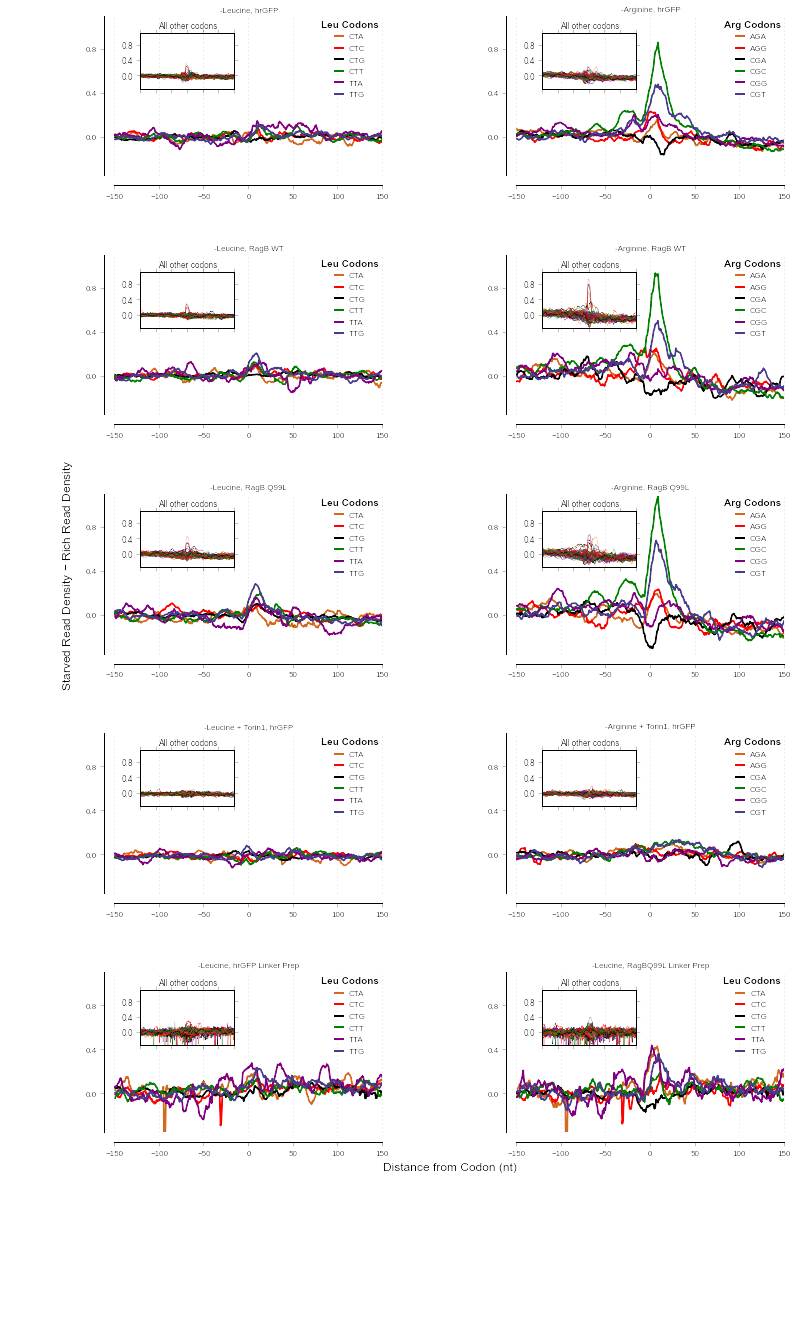

In [34]:
import cPickle as pickle
%matplotlib inline
top_samples = ['hrgfp_leu','hrgfp_arg','ragbwt_leu','ragbwt_arg','ragbq99l_leu','ragbq99l_arg','hrgfp_torin1leu','hrgfp_torin1arg','hrgfp_linker_leu','ragbq99l_linker_leu']
bottom_samples = ['hrgfp_rich','hrgfp_rich','ragbwt_rich','ragbwt_rich','ragbq99l_rich','ragbq99l_rich','hrgfp_torin1rich','hrgfp_torin1rich','hrgfp_linker_rich','hrgfp_linker_rich']

offset = 150

import matplotlib.pyplot as plt
import re
from matplotlib.ticker import MultipleLocator, NullLocator, MaxNLocator
from Bio.SeqUtils import CodonUsage
from matplotlib.transforms import Bbox


codon_number_dict = CodonUsage.CodonsDict.copy() # create local copy of codon dictionary.
    
for codon_number, codon in enumerate( sorted( codon_number_dict ) ):
    codon_number_dict[codon] = codon_number
codon_number_dict["start"] = 64 # assign numbers to different codons alphabetically.

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Liberation Sans'
plt.rcParams['font.size'] = 10

fig = plt.figure()
common_ax = plt.axes(frameon=False)
common_ax.set_xlabel('Distance from Codon (nt)', fontsize = "large")
common_ax.set_ylabel(r'Starved Read Density $\minus$ Rich Read Density', fontsize = "large")
common_ax.set_xticks([])
common_ax.set_yticks([])
common_ax.yaxis.labelpad = 40
common_ax.xaxis.labelpad = 30

fig.subplots_adjust( wspace=0.5, hspace=0.5 )

edge_colors = ["chocolate", "red", "black", "green", "purple", "darkslateblue"]
summedDensity = dict()
stallingIndex = dict()
for sampleIndex, sample in enumerate( top_samples ):
    sampleStats_top = pickle.load( open( '../sampleStats_' + top_samples[sampleIndex] + '.pickled', 'rb' ) )
    sampleStats_bottom = pickle.load( open( '../sampleStats_' + bottom_samples[sampleIndex] + '.pickled', 'rb' ) )
    
    summedDensity[top_samples[sampleIndex]] = dict()    
    if re.search( 'hrgfp_leu', top_samples[sampleIndex] ):
        subsetCodons = ['TTA', 'TTG', 'CTT', 'CTC', 'CTG', 'CTA']
        legendTitle = 'Leu Codons'
        axTitle = '-Leucine, hrGFP'
    elif re.search( 'hrgfp_arg', top_samples[sampleIndex] ):
        subsetCodons = ['AGA', 'AGG', 'CGA', 'CGC', 'CGG', 'CGT']
        legendTitle = 'Arg Codons'
        axTitle = '-Arginine, hrGFP'
    elif re.search( 'ragbwt_leu', top_samples[sampleIndex] ):
        subsetCodons = ['TTA', 'TTG', 'CTT', 'CTC', 'CTG', 'CTA']
        legendTitle = 'Leu Codons'
        axTitle = '-Leucine, RagB WT'
    elif re.search( 'ragbwt_arg', top_samples[sampleIndex] ):
        subsetCodons = ['AGA', 'AGG', 'CGA', 'CGC', 'CGG', 'CGT']
        legendTitle = 'Arg Codons'
        axTitle = '-Arginine, RagB WT'
    elif re.search( 'ragbq99l_leu', top_samples[sampleIndex] ):
        subsetCodons = ['TTA', 'TTG', 'CTT', 'CTC', 'CTG', 'CTA']
        legendTitle = 'Leu Codons'
        axTitle = '-Leucine, RagB Q99L'
    elif re.search( 'ragbq99l_arg', top_samples[sampleIndex] ):
        subsetCodons = ['AGA', 'AGG', 'CGA', 'CGC', 'CGG', 'CGT']
        legendTitle = 'Arg Codons'
        axTitle = '-Arginine, RagB Q99L'
    elif re.search( 'hrgfp_torin1leu', top_samples[sampleIndex] ):
        subsetCodons = ['TTA', 'TTG', 'CTT', 'CTC', 'CTG', 'CTA']
        legendTitle = 'Leu Codons'
        axTitle = '-Leucine + Torin1, hrGFP'
    elif re.search( 'hrgfp_torin1arg', top_samples[sampleIndex] ):
        subsetCodons = ['AGA', 'AGG', 'CGA', 'CGC', 'CGG', 'CGT']
        legendTitle = 'Arg Codons'
        axTitle = '-Arginine + Torin1, hrGFP'
    elif re.search( 'hrgfp_linker_leu', top_samples[sampleIndex] ):
        subsetCodons = ['TTA', 'TTG', 'CTT', 'CTC', 'CTG', 'CTA']
        legendTitle = 'Leu Codons'
        axTitle = '-Leucine, hrGFP Linker Prep'
    elif re.search( 'ragbq99l_linker_leu', top_samples[sampleIndex] ):
        subsetCodons = ['TTA', 'TTG', 'CTT', 'CTC', 'CTG', 'CTA']
        legendTitle = 'Leu Codons'
        axTitle = '-Leucine, RagBQ99L Linker Prep'
        
    
    ax = fig.add_subplot( int(numpy.ceil(len(top_samples)/2.0)),2,sampleIndex+1)     
    temp = list()
    
    for codonIndex, codon in enumerate( sorted( filter( lambda codon: codon in subsetCodons, codon_number_dict ) ) ):
        x_vector = numpy.arange(-offset,+offset+1)
        y_vector = sampleStats_top['codonRibosomeOccupancyMedian'][codon] - sampleStats_bottom['codonRibosomeOccupancyMedian'][codon]
        
        ax.plot(x_vector, y_vector, color = edge_colors[codonIndex], label=codon, linewidth=2, marker=None);        
        #print sample, codon, y_vector[offset-30:offset+50].sum() - min(temp) + 1    
    
    for loc, spine in ax.spines.items():
        if loc in ['left','bottom']:
            spine.set_position(('outward',10)) # outward by 10 points
        elif loc in ['right','top']:
            spine.set_color('none') # don't draw spine
        else:
            raise ValueError('unknown spine location: %s'%loc)

    # turn off ticks where there is no spine
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_major_locator(MaxNLocator(7))
    ax.xaxis.set_ticks_position('bottom')
    ax.set_ylim(bottom=-0.35, top=1.1)
    ax.yaxis.set_major_locator(MaxNLocator(5, prune=None))
    ax.yaxis.set_ticks_position('left')
    ax.set_xlim(-offset,+offset)
    ax.xaxis.grid()
    
    ax.set_title( axTitle )
    temp = ax.legend(frameon=False, title=legendTitle)
    temp.get_title().set_fontweight( 'bold' )
    
    bboxvalues = ax.get_position().get_points()
    left = bboxvalues[0,0] + 0.03
    bottom = bboxvalues[0,1] + 0.06  #adjust this value if the height of the box is off-- higher makes it go up relative to its plot and lower makes it go down.
    width = 0.35* ( bboxvalues[1,0]-bboxvalues[0,0] )
    height = 0.35* ( bboxvalues[1,1]-bboxvalues[0,1] )
    
    ax2 = fig.add_axes([left,bottom,width,height])
    
    for codonIndex, codon in enumerate( sorted( filter( lambda codon: codon not in subsetCodons, codon_number_dict ) ) ):
        x_vector = numpy.arange(-offset,+offset+1)
        
        if codon in ['TGA','TAA','TAG','start']:
            continue
        yvector = sampleStats_top['codonRibosomeOccupancyMedian'][codon] - sampleStats_bottom['codonRibosomeOccupancyMedian'][codon]
        
        
        ax2.plot(x_vector, yvector,    
            color = edge_colors[numpy.mod(codonIndex,6)], label=codon, linewidth=0.5, marker=None);
        
    ax2.set_xlim(ax.get_xlim())
    ax2.set_ylim(ax.get_ylim())
    [i.set_fontsize( 'small' ) for i in ax2.get_yticklabels()]
    ax2.xaxis.set_major_locator(ax.xaxis.get_major_locator())    
    ax2.yaxis.set_major_locator(ax.yaxis.get_major_locator())    
    ax2.xaxis.set_ticklabels([])
    #ax2.yaxis.set_ticklabels([])
    ax2.set_title( 'All other codons', fontsize='small')  
    
fig.set_size_inches([12,4 * numpy.ceil(len(top_samples)/2.0)])
#fig.savefig( 'hrgfp-ragbs_allconditionsvsmatchedcelllinerich_mean.svg' )

###Plot median ribosome occupancy around all 64 codons

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


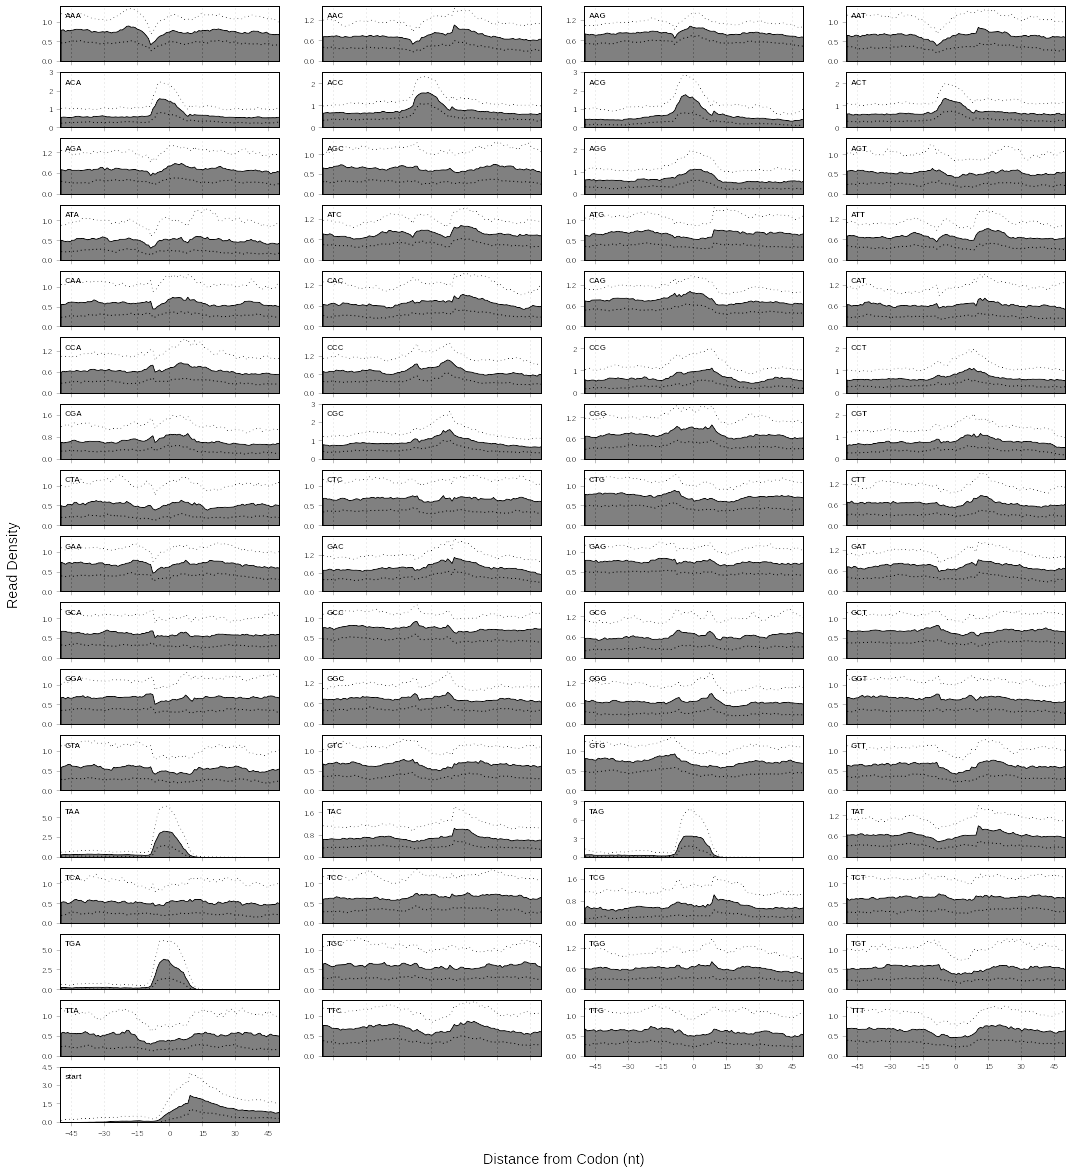

In [31]:
import cPickle as pickle
%pylab inline
offset = 50   

import matplotlib.pyplot as plt
import re
from matplotlib.ticker import MultipleLocator, NullLocator, MaxNLocator
from Bio.SeqUtils import CodonUsage

codon_number_dict = CodonUsage.CodonsDict.copy() # create local copy of codon dictionary.
    
for codon_number, codon in enumerate( sorted( codon_number_dict ) ):
    codon_number_dict[codon] = codon_number
codon_number_dict["start"] = 64 # assign numbers to different codons alphabetically.

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 12

fig = plt.figure()
common_ax = plt.axes(frameon=False)
common_ax.set_xlabel('Distance from Codon (nt)', fontsize = "larger")
common_ax.set_ylabel(r'Read Density', fontsize = "larger")
common_ax.set_xticks([])
common_ax.set_yticks([])
common_ax.yaxis.labelpad = 40
common_ax.xaxis.labelpad = 30

sampleStats = pickle.load( open('../20160303_mtorperturbRP_analysis/Lane1/processedData_oldmethod/sampleStats_ragbwt_arg.pickled'))

for codonIndex, codon in enumerate( sorted( codon_number_dict ) ):
    x_vector = numpy.arange(-offset,+offset+1)
    ax = fig.add_subplot(17,4,codonIndex+1)
    plt.fill_between(x_vector, sampleStats['codonRibosomeOccupancyMedian'][codon][offset+50:+offset+150+1],        
        edgecolor = 'black', facecolor = 'grey' );
    plt.plot(x_vector, sampleStats['codonRibosomeOccupancy25'][codon][offset+50:+offset+150+1], ":k");
    plt.plot(x_vector, sampleStats['codonRibosomeOccupancy75'][codon][offset+50:+offset+150+1], ":k");    
    ax.set_title(codon, x=0.02, y=0.7, ha = 'left', fontweight="bold");
    if codonIndex < 62:
        ax.xaxis.set_ticklabels([])
    ax.xaxis.set_major_locator(MaxNLocator(8))
    ax.xaxis.set_ticks_position('bottom')
    ax.set_ylim(bottom=0)
    ax.yaxis.set_major_locator(MaxNLocator(3, prune=None))
    ax.yaxis.set_ticks_position('left')
    ax.set_xlim(-offset,+offset)#plt.ylim((0,max([plt.ylim()[1],2])));
    ax.xaxis.grid()
fig.set_size_inches([18,20])

#this is a series of 64 plots of the ribosome occupancy (normalized occupancy counts) across all possible codons - look from a certain offet ,
#also the dotted lines are quartile boundaries (75% of the data falls under top line, for example). Can change the sample, the offset, *make sure the locations of the 
#pickled file in sampleStats is correct. If the offset is changed, make the corresponding change later in the codon [never change x_vector, just change offset and adjust scale when plotting with plt. ]

###Calculate occupancy differences in various nt ranges around codon 1) sum, centered around codon 2) mean, upstream of codon 3) mean, downstream of codon 4) subtract means upstream & downstream of codons

In [ ]:
import cPickle as pickle

top_samples = ['hrgfp_leu','hrgfp_arg','ragbwt_leu','ragbwt_arg','ragbq99l_leu','ragbq99l_arg','hrgfp_torin1leu','hrgfp_torin1arg','hrgfp_linker_leu','ragbq99l_linker_leu']
bottom_samples = ['hrgfp_rich','hrgfp_rich','ragbwt_rich','ragbwt_rich','ragbq99l_rich','ragbq99l_rich','hrgfp_torin1rich','hrgfp_torin1rich','hrgfp_linker_rich','hrgfp_linker_rich']

offset = 150

import re
from Bio.SeqUtils import CodonUsage
import pandas
from IPython.core.display import HTML


codon_number_dict = CodonUsage.CodonsDict.copy() # create local copy of codon dictionary.
    
for codon_number, codon in enumerate( sorted( codon_number_dict ) ):
    codon_number_dict[codon] = codon_number
codon_number_dict["start"] = 64 # assign numbers to different codons alphabetically.

summedCenterDensity = dict()
upstreamMeanDensity = dict()
downstreamMeanDensity = dict()
dropoffSubtractedMeanDensity = dict()

for sampleIndex, sample in enumerate( top_samples ):
    sampleStats_top = pickle.load( open( '../sampleStats_' + top_samples[sampleIndex] + '.pickled', 'rb' ) )
    sampleStats_bottom = pickle.load( open( '../sampleStats_' + bottom_samples[sampleIndex] + '.pickled', 'rb' ) )
    
    summedCenterDensity[top_samples[sampleIndex]] = dict()
    upstreamMeanDensity[top_samples[sampleIndex]] = dict()
    downstreamMeanDensity[top_samples[sampleIndex]] = dict()
    dropoffSubtractedMeanDensity[top_samples[sampleIndex]] = dict()
    
    if re.search( 'hrgfp_leu', top_samples[sampleIndex] ):
        subsetCodons = ['TTA', 'TTG', 'CTT', 'CTC', 'CTG', 'CTA']
        
    elif re.search( 'hrgfp_arg', top_samples[sampleIndex] ):
        subsetCodons = ['AGA', 'AGG', 'CGA', 'CGC', 'CGG', 'CGT']
        
    elif re.search( 'ragbwt_leu', top_samples[sampleIndex] ):
        subsetCodons = ['TTA', 'TTG', 'CTT', 'CTC', 'CTG', 'CTA']
        
    elif re.search( 'ragbwt_arg', top_samples[sampleIndex] ):
        subsetCodons = ['AGA', 'AGG', 'CGA', 'CGC', 'CGG', 'CGT']
        
    elif re.search( 'ragbq99l_leu', top_samples[sampleIndex] ):
        subsetCodons = ['TTA', 'TTG', 'CTT', 'CTC', 'CTG', 'CTA']
        
    elif re.search( 'ragbq99l_arg', top_samples[sampleIndex] ):
        subsetCodons = ['AGA', 'AGG', 'CGA', 'CGC', 'CGG', 'CGT']
        
    elif re.search( 'hrgfp_torin1leu', top_samples[sampleIndex] ):
        subsetCodons = ['TTA', 'TTG', 'CTT', 'CTC', 'CTG', 'CTA']
        
    elif re.search( 'hrgfp_torin1arg', top_samples[sampleIndex] ):
        subsetCodons = ['AGA', 'AGG', 'CGA', 'CGC', 'CGG', 'CGT']
        
    elif re.search( 'hrgfp_linker_leu', top_samples[sampleIndex] ):
        subsetCodons = ['TTA', 'TTG', 'CTT', 'CTC', 'CTG', 'CTA']
        
    elif re.search( 'ragbq99l_linker_leu', top_samples[sampleIndex] ):
        subsetCodons = ['TTA', 'TTG', 'CTT', 'CTC', 'CTG', 'CTA']
             
    
    for codonIndex, codon in enumerate( sorted( filter( lambda codon: codon in subsetCodons, codon_number_dict ) ) ):
        x_vector = numpy.arange(-offset,+offset+1)
        y_vector = sampleStats_top['codonRibosomeOccupancyMedian'][codon] - sampleStats_bottom['codonRibosomeOccupancyMedian'][codon]
        
        ax.plot(x_vector, y_vector, color = edge_colors[codonIndex], label=codon, linewidth=2, marker=None)
        summedCenterDensity[top_samples[sampleIndex]][codon] = y_vector[offset-50:offset+50].sum() # a bit weird since the pause occurs over different area for each codon (ie depending on number of pileups)
        upstreamMeanDensity[top_samples[sampleIndex]][codon] = y_vector[offset-150:offset-100].mean()
        downstreamMeanDensity[top_samples[sampleIndex]][codon] = y_vector[offset+100:offset+150].mean()
        dropoffSubtractedMeanDensity[top_samples[sampleIndex]][codon] = upstreamMeanDensity[top_samples[sampleIndex]][codon] - downstreamMeanDensity[top_samples[sampleIndex]][codon]
dropoffData = pandas.DataFrame.from_dict( dropoffSubtractedMeanDensity )
HTML(dropoffData.to_html())

#dataframe of each condition compared to matched rich conditions, upstream 150-100 mean - downstream 100-150 mean.  So positive #s mean there was a higher occupancy in starved v rich upstream of the pause site, and neg numbers means there was a lower occupancy in starved v rich upstream of the pause site.